# Bild Kompression

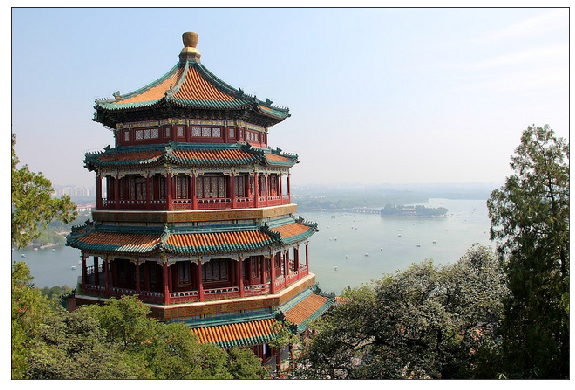

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image
plt.rcParams["figure.figsize"] = (10,8)

china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

Das Bild selbst ist als 3-dimensionale Matrix gespeichert (height, width, RGB):

In [4]:
print('Shape: {}'.format(china.shape))
china

Shape: (427, 640, 3)


array([[[174, 201, 231],
        [174, 201, 231],
        [174, 201, 231],
        ...,
        [250, 251, 255],
        [250, 251, 255],
        [250, 251, 255]],

       [[172, 199, 229],
        [173, 200, 230],
        [173, 200, 230],
        ...,
        [251, 252, 255],
        [251, 252, 255],
        [251, 252, 255]],

       [[174, 201, 231],
        [174, 201, 231],
        [174, 201, 231],
        ...,
        [252, 253, 255],
        [252, 253, 255],
        [252, 253, 255]],

       ...,

       [[ 88,  80,   7],
        [147, 138,  69],
        [122, 116,  38],
        ...,
        [ 39,  42,  33],
        [  8,  14,   2],
        [  6,  12,   0]],

       [[122, 112,  41],
        [129, 120,  53],
        [118, 112,  36],
        ...,
        [  9,  12,   3],
        [  9,  15,   3],
        [ 16,  24,   9]],

       [[116, 103,  35],
        [104,  93,  31],
        [108, 102,  28],
        ...,
        [ 43,  49,  39],
        [ 13,  21,   6],
        [ 15,  24,   7]]

Wir wandeln die Matrix um in (height * width, 3) und skalieren die Farben auf [0, 1]:

In [5]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
print('Shape: {}'.format(data.shape))
data

Shape: (273280, 3)


array([[0.68235294, 0.78823529, 0.90588235],
       [0.68235294, 0.78823529, 0.90588235],
       [0.68235294, 0.78823529, 0.90588235],
       ...,
       [0.16862745, 0.19215686, 0.15294118],
       [0.05098039, 0.08235294, 0.02352941],
       [0.05882353, 0.09411765, 0.02745098]])

Die "Farbwolke" können wir visualisieren (aus Effizienzgründen ein Subsample von 10.000 Punkten):

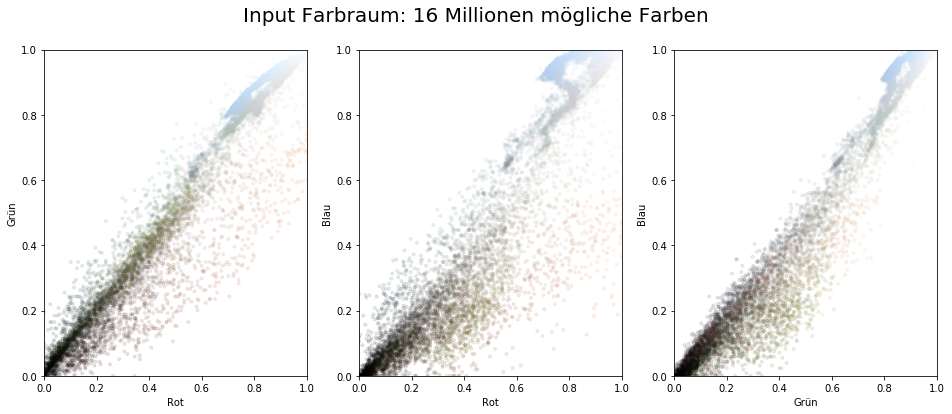

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.default_rng(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 3, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.', alpha=0.1)
    ax[0].set(xlabel='Rot', ylabel='Grün', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.', alpha=0.1)
    ax[1].set(xlabel='Rot', ylabel='Blau', xlim=(0, 1), ylim=(0, 1))

    ax[2].scatter(G, B, color=colors, marker='.', alpha=0.1)
    ax[2].set(xlabel='Grün', ylabel='Blau', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)

plot_pixels(data, title='Input Farbraum: 16 Millionen mögliche Farben')

Oder als 3-D:

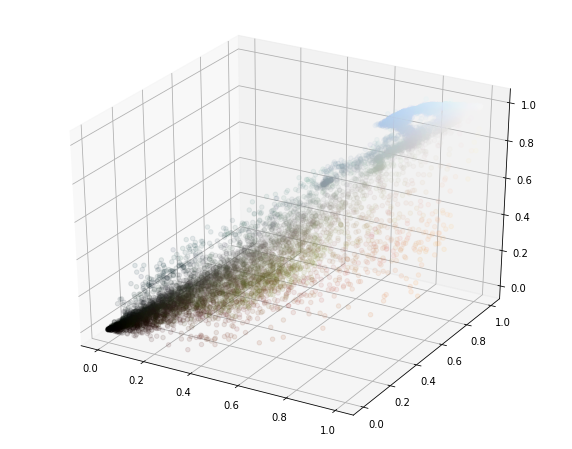

In [7]:
from mpl_toolkits.mplot3d import Axes3D # brauchen wir, damit 3d funktioniert, Axes3D brauchen wir hier nicht
ax = plt.axes(projection='3d')

rng = np.random.default_rng(0)
i = rng.permutation(data.shape[0])[:10000]
R, G, B = data[i].T
ax.scatter(R, G, B, c=data[i], alpha=0.1);

Jetzt reduzieren wir diese 16 Millionen Farben zu nur noch 16 Farben mittels MiniBatch-k-Means.

> **MiniBatchKMeans** ist eine Variante des KMeans-Algorithmus, der Mini-Batches verwendet, um die Berechnungszeit zu reduzieren. Der Algorithmus iteriert zwischen zwei Hauptschritten: 
   - Im ersten Schritt werden nach dem Zufallsprinzip Stichproben aus dem Datensatz gezogen, um einen Minibatch zu bilden. Diese werden dann dem nächstgelegenen Zentroid zugeordnet. 
   - Im zweiten Schritt werden die Zentroide aktualisiert. Im Gegensatz zu k-Means erfolgt dies pro Stichprobe. Für jede Probe in den Minibatch-Chargen wird der zugeordnete Mittelwert aktualisiert, indem der laufende Mittelwert der Probe und aller vorhergehenden Proben, die diesem Schwerpunkt zugeordnet sind, gebildet wird. Dies hat zur Folge, dass die Änderungsrate für einen Zentroid im Laufe der Zeit abnimmt. 

> Diese Schritte werden durchgeführt, bis die Konvergenz oder eine vorgegebene Anzahl von Iterationen erreicht ist.

> MiniBatchKMeans konvergiert schneller als KMeans, aber die Qualität der Ergebnisse wird verringert. In der Praxis ist dieser Qualitätsunterschied recht gering sein, siehe Beispiel.

![](./MiniBatch-Verlust.png)

In [8]:
n_clusters = 16

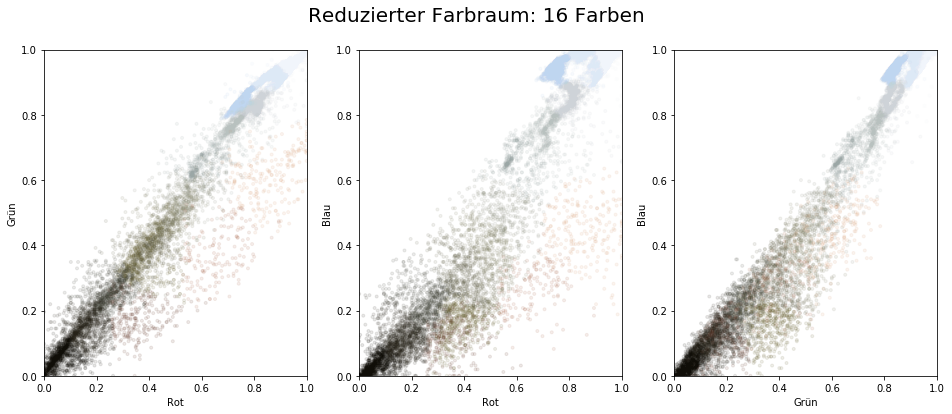

In [10]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduzierter Farbraum: {} Farben".format(n_clusters))

Im Ergebnis ist jedem Pixel der Farbwert eines der 16 des Cluster zugewiesen, diese sind (wieder auf 255 hoch-skaliert):

In [11]:
255*kmeans.cluster_centers_

array([[ 97.76615924,  90.15764725,  39.66007811],
       [220.52343554, 232.67303343, 246.20916059],
       [ 15.97190818,  14.27188749,   8.34751137],
       [142.38550517, 144.69157539, 128.11945951],
       [205.91392392, 210.92713934, 216.19124667],
       [126.16220306, 125.40134665,  96.18429414],
       [101.98376927,  99.81603223,  76.51798225],
       [217.56912776, 155.61400651, 113.26293883],
       [155.22479478, 167.07882551, 165.50663018],
       [ 64.77664708,  67.20845573,  56.29637012],
       [241.24377713, 245.075261  , 251.33027566],
       [ 89.9994846 ,  44.48125242,  28.35446463],
       [184.24562967, 193.42304792, 191.12737369],
       [166.73013175,  97.2441564 ,  68.24925627],
       [191.3354719 , 214.03683234, 239.71349617],
       [ 42.01384169,  38.35450297,  28.28472812]])

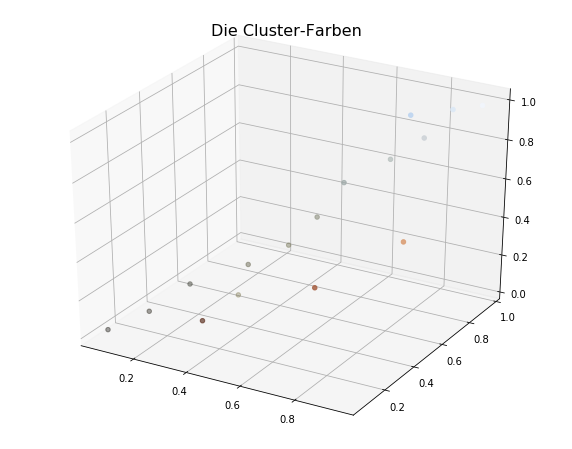

In [12]:
R, G, B = kmeans.cluster_centers_.T
ax = plt.axes(projection='3d')

ax.scatter(R, G, B, c=kmeans.cluster_centers_)
ax.set_title('Die Cluster-Farben', size=16);

Angewandt auf das Bild:

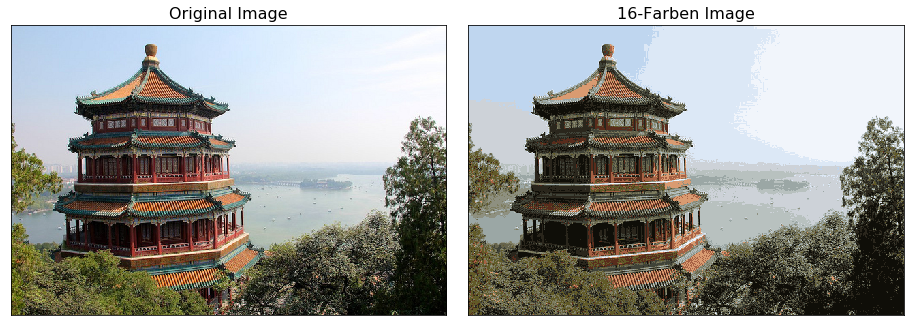

In [13]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-Farben Image', size=16);

(Natürlich gibt es bessere Kompressionsalgorithmen, trotzdem:) Cool

Offensichtlich ist bei solch gleitenden Farbübergängen die Clustertrennung nicht optimal. Das können wir uns ja auch mit dem Silhouette Score anschauen:

In [ ]:
from SilhouettePlot import PlotSilhouette

# get Sample of Data
X = data[rng.permutation(data.shape[0])[:10000]]
PlotSilhouette(X, kmeans, n_clusters=n_clusters)